# Algorithmic Trading: Take-home Exam

Name: Mark de Kwaasteniet

Student ID: 2649271






#### Load the packages needed for the algorithm

In [147]:
''' Load the packages needed for the algorithm'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import time
import logging

#### Load the pre-made packages provided by Optiver

In [148]:
from cointegration_analysis import estimate_long_run_short_run_relationships, engle_granger_two_step_cointegration_test
from optibook.synchronous_client import Exchange
from math import floor, ceil, copysign
from black_scholes import call_value, put_value, call_delta, put_delta, vol_bs_put, vol_bs_call
from libs import calculate_current_time_to_date

## Question 1

### Task 1

#### Read the CSV file - Transform into log-prices

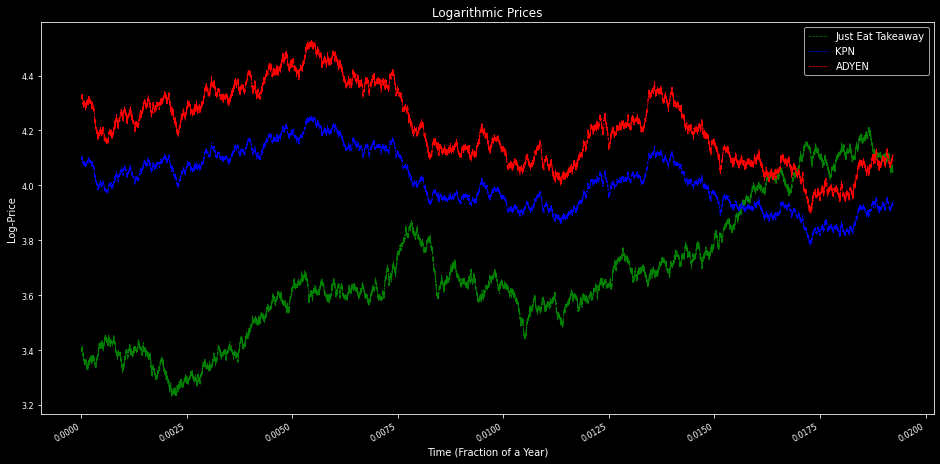

In [151]:
#Reading the data
data = pd.read_csv('data.csv', index_col=0)
log_data = np.log(data)

# Plot the Results
plt.style.use('dark_background')
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
plt.plot(log_data.TKWY, 'g--', label="Just Eat Takeaway", linewidth=0.7)
plt.plot(log_data.KPN, 'b--', label="KPN", linewidth=0.7)
plt.plot(log_data.ADYEN, 'r--', label="ADYEN", linewidth=0.7)
plt.title("Logarithmic Prices")
plt.ylabel("Log-Price")
plt.xlabel("Time (Fraction of a Year)")
fig.autofmt_xdate()
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.legend()
plt.show()

#### Find a cointegration relationship between KPN an another stock

In [160]:
# Create a list and change order in a second list for cross-referencing
tickers = log_data.columns
tickers_rev = [stocks[i] for i in [2, 0, 1]]

# Iterate over the list of tickers and cross-reference them to find cointegrated pairs'''
for i in range(len(tickers)):
    
    # If the tickers are the same, don't test for cointegration
    if tickers[i] != tickers_rev[i]:
        
        # To keep the notebook organized, store the series temporarily in X and Y
        X = log_data[tickers[i]]
        Y = log_data[tickers_rev[i]]
        
        # Test cointegration both ways in order to significantly reject the null-hypothesis of 'no cointegration'
        result_1 = engle_granger_two_step_cointegration_test(Y, X)
        result_2 = engle_granger_two_step_cointegration_test(X, Y)
        
        # Print the cointegration status of the pair
        if result_1[1] < 0.05 and result_2[1] < 0.05:
            print(f"{tickers[i]} and {tickers_rev[i]} are cointegrated")
        else:
            print(f"{tickers[i]} and {tickers_rev[i]} are not cointegrated")

TKWY and KPN are not cointegrated
ADYEN and TKWY are not cointegrated
KPN and ADYEN are cointegrated


KPN and ADYEN are significantly cointegrated. Estimate the long-run relationship between the two stocks estimating the first stage regression using the EG2SLS method
### Task 2

In [182]:
# Estimate the long run relationship
LR_model = estimate_long_run_short_run_relationships(log_data.KPN, log_data.ADYEN)

# Store the parameters of the long run relationship
constant_lr = result[0]
gamma_coef_lr = result[1]

# Store the parameters of the short run relationship
alpha_coef_sr = result[2]

# Store the residuals from the long run relationship
residuals_lr = result[3]

# Calculate the correct trade ratio between these stocks
trade_ratio_YX = (gamma_coef_lr * data.KPN.iloc[0] / data.ADYEN.iloc[0])
print(f"Using the first row of the given data set; \n")
print(f"If we hold 1 lot of KPN, then according to our trade ratio, we should sell {trade_ratio_YX:.3f} lots of ADYEN in order to be hedged")

Using the first row of the given data set; 

If we hold 1 lot of KPN, then according to our trade ratio, we should sell 0.602 lots of ADYEN in order to be hedged


### Task 3
Create a cointegration based pairs strategy and test it on Optibook. 

For this strategy the given historical data will be used to estimate the relationships and model parameters.


In [196]:
''' Define the functions needed for the cointegration strategy. Some functions are already defined for question 2'''
def round_down_to_tick(price, tick_size):
    """
    Rounds a price down to the nearest tick, e.g. if the tick size is 0.10, a price of 0.97 will get rounded to 0.90.
    """
    return floor(price / tick_size) * tick_size

def round_up_to_tick(price, tick_size):
    """
    Rounds a price up to the nearest tick, e.g. if the tick size is 0.10, a price of 1.34 will get rounded to 1.40.
    """
    return ceil(price / tick_size) * tick_size

def get_option_ids(instrument, expiry_date, strike_prices, option_type):
    options = []
    for strike_price in strike_prices:
        options.append(f'{instrument}-{expiry_date}-{strike_price}{option_type}')
    return options

class Instrument():
    def __init__(self, order_book):
        self.best_bid = order_book.bids[0].price
        self.best_ask = order_book.asks[0].price
        
    def get_price(self):
        return float((self.best_bid + self.best_ask)/2)
    
    def get_spread(self):
        return (self.best_ask - self.best_bid)
    
def hack_out_of_position(e):
    ''' Retrieve current positions in the market from the exchange '''
    positions = e.get_positions()
    
    for s, p in e.get_positions().items():
        if p > 0:
            e.insert_order(s, price=1, volume=p, side='ask', order_type='ioc')
        elif p < 0:
            e.insert_order(s, price=100000, volume=-p, side='bid', order_type='ioc')
        time.sleep(0.10)
        
    positions = e.get_positions()

def book_checker(instrument):
    book = e.get_last_price_book(instrument)
    while (not book.asks) or (not book.bids):
        time.sleep(0.05)
        book = e.get_last_price_book(instrument)
    return book

In [195]:
''' Set initial parameters and lists in place '''
instrument_Y = "KPN" 
instrument_X = "ADYEN"
residuals_lr = np.array(residuals_lr)
position_taken = False
long_short_taken = False
short_long_taken = False

# If we increase the allowed spread we will definitely be rolled over by the boulder whilst picking up pennies
max_spread_underlying = 0.2 
max_volume = 200
trade_volume = 20
update_time = 1
threshold = 2.5
stop_loss = 0.5

e = Exchange()
a = e.connect()

logging.getLogger('client').setLevel('ERROR')
print("Setup was successful.")

hack_out_of_position(e)
while True:
    
    # Check the start time with the end time of the loop in order to restrict the update time to one second
    start_time = time.time()
    
    # Get the order book of the instruments
    book_Y = book_checker(instrument_Y)
    book_X = book_checker(instrument_X)
    
    # Store the instrument unweighted mid-point prices
    Y = Instrument(book_Y).get_price()
    X = Instrument(book_X).get_price()
    
    # Store the instrument spreads
    Y_spread = Instrument(book_Y).get_spread()
    X_spread = Instrument(book_X).get_spread()
    
    # Append residuals based on the current incoming data to the residuals of the historical data
    residuals_lr = np.append(residuals_lr, (np.log(Y) -  constant_lr - gamma_coef_lr * np.log(X)))
    
    # Append the trading ratio based on the current prices to the list
    trade_ratio.append(gamma_coef_lr * Y / X)
    
    # Use the past 100 residuals to determine the standard deviation and the mean of the residuals
    std_dev = np.std(np.array(residuals_lr[-100:]))
    mean = np.mean(np.array(residuals_lr[-100:]))

    # Using the standard deviation and the mean of the residuals we can standardize the residuals and create z-scores
    z = (residuals_lr[-1] - mean) / std_dev
    
    print(f"Standardized Residual = {z}")
    
    # If the spread between the bid-ask is lower than the max_spread then we consider trading in the pairs.
    if (Y_spread < max_spread_underlying) and (X_spread < max_spread_underlying):
        
        # When the z-score of the residual is bigger the threshold do we consider trading
        if (z > threshold and position_taken == False) or (z < -threshold and position_taken == False):
            
            # Retrieve the current positions in the stocks
            positions = e.get_positions()
            stock_position_Y = positions[instrument_Y]
            stock_position_X = positions[instrument_X]

            #Calculate the possible total volume to trade given the max volume and the current position
            volume_to_trade = -(copysign(1,z) * max_volume + stock_position_Y)
            print(f"Volume to Trade: {volume_to_trade}")

            # Calculate the possible total volume to hedge
            rest_volume_hedge = abs(copysign(1,z) * max_volume - stock_position_X)
            
            # Determine value to hedge. This value might not exceed the maximum volume you can hedge
            needed_volume_hedge = abs(volume_to_trade * abs(trade_ratio[-1]))                       
            volume_to_hedge = round(min(needed_volume_hedge, rest_volume_hedge))
            print(f"Volume to Hedge: {volume_to_hedge}")

            ''' Place buy or sell order for the underlying stock'''
            # set the bid and the ask price in order for the order to be executed directly
            price_bid = 1000 
            price_ask = 1
            
            # If the volume to trade in Y is positive, we should buy Y and sell X
            if volume_to_trade > 0:
                e.insert_order(instrument_Y, price=price_bid, volume=volume_to_trade, side='bid', order_type='ioc')
                e.insert_order(instrument_X, price=price_ask, volume=volume_to_hedge, side='ask', order_type='ioc')
                
                #Set boolean to indicate whether you are in a position or not
                position_taken = True
                long_short_taken = True
                
            # If the volume to trade in Y is negative, we should sell Y and buy X
            elif volume_to_trade < 0:
                e.insert_order(instrument_Y, price=price_ask, volume=-volume_to_trade, side='ask', order_type='ioc')
                e.insert_order(instrument_X, price=price_bid, volume=volume_to_hedge, side='bid', order_type='ioc')
                position_taken = True
                short_long_taken = True
            else: 
                print('You are perfectly hedged')
                
        elif (position_taken == True) and (short_long == True):
            if z < -stop_loss:
                hack_out_of_position(e)
                short_long_taken = False
                position_taken = False
        elif (position_taken == True) and (long_short == True):
            if z > stop_loss:
                hack_out_of_position(e)
                long_short_taken = False
                position_taken = False

    while time.time() - start_time < update_time:
        time.sleep(0.1)
        
    
    

2022-03-22 21:15:13,746 [asyncio   ] [MainThread  ] Using selector: EpollSelector
2022-03-22 21:15:13,927 [client    ] [Thread-19   ] Forcing a disconnect due to an error: Closing connection because someone else logged in with the same credentials. Only one session may be active at the same time.


Setup was successful.


KeyboardInterrupt: 

## Question 2

In [206]:
''' Import additional packages to perform the advanced cointegration based strategy '''
from statsmodels.tsa.vector_ar import vecm
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
from black_scholes import call_value, put_value, call_delta, put_delta, call_vega, put_vega

In [207]:
def delete_outstanding(instrument):
    ''' Delete all currently outstanding orders '''
    outstanding = e.get_outstanding_orders(instrument)
    for o in outstanding.values():
        result = e.delete_order(instrument, order_id=o.order_id)

# Using the Newton Raphson method to calibrate between the estimated price and the order price
# In order to obtain the implied volatility in the market. 
# Return the implied volatility and the estimated price.
def vol_bs_call(S, K, T, r, sigma, call_market):
    max_iter = 100
    tol = 0.001
    vol_old = sigma
    
    for k in range(max_iter):
        bs_price = call_value(S, K, T, r, vol_old)
        vega = call_vega(S,K,T,r,vol_old)
        C = bs_price - call_market
        vol_new = vol_old - C/vega
        new_bs_price = call_value(S, K, T, r, vol_new)
        if (abs(vol_old-vol_new) < tol or abs(new_bs_price-call_market) < tol):
            break
        
        vol_old = vol_new
    
    return vol_new, new_bs_price 

def vol_bs_put(S, K, T, r, sigma, put_market):
    max_iter = 100
    tol = 0.001
    vol_old = sigma
    
    for k in range(max_iter):
        bs_price = put_value(S, K, T, r, vol_old)
        vega = put_vega(S,K,T,r,vol_old)
        C = bs_price - put_market
        vol_new = vol_old - C/vega
        new_bs_price = put_value(S, K, T, r, vol_new)
        if (abs(vol_old-vol_new) < tol or abs(new_bs_price-put_market) < tol):
            break
        
        vol_old = vol_new
    
    return vol_new, new_bs_price

In [224]:
#This function tests whether there is cointegration in the two log-price arrays
def coint_tester(Y,X, cointegration):
    
    ln_Y = np.log(Y[-200:]) 
    ln_X = np.log(X[-200:])
    result_1 = engle_granger_two_step_cointegration_test(pd.Series(ln_Y), pd.Series(ln_X))
    result_2 = engle_granger_two_step_cointegration_test(pd.Series(ln_X), pd.Series(ln_Y))
    
    #Test whether the results are both ways significant
    if result_1[1] < 0.01 and result_2[1] < 0.01:
        print(f"KPN and ADYEN are cointegrated")
        
        #If they are significant we can estimate the VECM
        df_pair = pd.concat([pd.Series(ln_Y), pd.Series(ln_X)], axis=1)
        p_max = int(12*(int(len(df_pair))/100)**0.25)    
        
        #Determine the optimal order length on the basis of AIC information criteria
        lag_order = vecm.select_order(df_pair, maxlags=p_max, deterministic="ci") 
        
        #Fit the model only with a constant inside the long run relationship
        fitted_model = vecm.VECM(df_pair, k_ar_diff=lag_order.aic, coint_rank=1, deterministic="ci").fit()
        
        #Return the parameters for trading
        constant_lr = fitted_model.const_coint[0][0]
        gamma_coef_lr = -fitted_model.beta[1][0]
        residuals_lr = (np.log(Y[-100:])  -  constant_lr - gamma_coef_lr * np.log(X[-100:]) )
        cointegration == True
    else:
        constant_lr = 0
        gamma_coef_lr = 0
        residuals_lr = 0
        cointegration == False
        print(f"KPN and ADYEN are not cointegrated")
    
    return constant_lr, gamma_coef_lr,residuals_lr, cointegration
    

In [225]:
def vecm_cointegration(Y,X,constant_lr, gamma_coef_lr, residuals_lr, max_spread_underlying, position_taken, long_short_taken, short_long_taken, coint):       
    if coint == True:
        #If cointegration is true. Use the estimated parameters of the past 200 seconds to estimate the current residual
        instrument_Y = "KPN" 
        instrument_X = "ADYEN"
        coint_trade_volume = 20
        max_volume = 150
        threshold = 2.5
        stop_loss = 0.5
    
        #Append the residual to the list
        residuals_lr = np.append(residuals_lr, (np.log(Y[-1])  -  constant_lr - gamma_coef_lr * np.log(X[-1]) ))
        
        #Calculate the trade ratio again
        trade_ratio = (gamma_coef_lr * Y[-1] / X[-1])
        
        #Convert the residuals to Z-scores
        std_dev = np.std(np.array(residuals_lr[-100:]))
        mean = np.mean(np.array(residuals_lr[-100:]))
        z = (residuals_lr[-1] - mean) / std_dev

        # If the spread between the bid-ask is lower than 0.2 then we consider cointegration trading
        if (Y_spread[-1] < max_spread_underlying) and (X_spread[-1] <= max_spread_underlying):
            
            # When the z-score of the residual is bigger the threshold do we consider trading
            if (z > threshold and position_taken == False) or (z < -threshold and position_taken == False):
                
                #Check the current positions in the stock to check what volume we can trade on
                positions = e.get_positions()
                stock_position_Y = positions[instrument_Y]
                stock_position_X = positions[instrument_X]

                #total_trade possibility given the max volume and the current position
                # If the residual is positive, KPN will mean revert negatively. Thus, sell KPN
                volume_to_trade = -(copysign(1,z) * max_volume + stock_position_Y)
                volume_to_trade = copysign(min(abs(volume_to_trade), abs(coint_trade_volume)), volume_to_trade)

                # Determine value to hedge. If this value exceeds max_volume possible, take that value
                needed_volume_hedge = abs(volume_to_trade * abs(trade_ratio))                       
                volume_to_hedge = round(min(needed_volume_hedge, 200))
                volume_to_hedge = min(volume_to_hedge, coint_trade_volume)

                # if volume_to_hedge != 0:
                ''' Place buy or sell order for the underlying stock to hedge position'''
                price_bid = 1000 
                price_ask = 1
                if volume_to_trade > 0:
                    long_short = True
                    e.insert_order(instrument_Y, price=price_bid, volume=volume_to_trade, side='bid', order_type='ioc')
                    e.insert_order(instrument_X, price=price_ask, volume=volume_to_hedge, side='ask', order_type='ioc')
                elif volume_to_trade < 0:
                    short_long = True
                    e.insert_order(instrument_Y, price=price_ask, volume=-volume_to_trade, side='ask', order_type='ioc')
                    e.insert_order(instrument_X, price=price_bid, volume=volume_to_hedge, side='bid', order_type='ioc')

                else: 
                    print('You are perfectly hedged')

            # When the z-score of the residuals is lower than threshold/3 hack out of posisitions
            elif (position_taken == True) and (short_long == True):
                if z < -stop_loss:
                    hack_out_of_position(e)
                    short_long_taken = False
                    position_taken = False
            elif (position_taken == True) and (long_short == True):
                if z > stop_loss:
                    hack_out_of_position(e)
                    long_short_taken = False
                    position_taken = False


In [ ]:
''' Set initial parameters and lists in place '''
tick_size = 0.1
residuals_lr = np.array(residuals_lr)
position_taken = False
long_short_taken = False
short_long_taken = False
Y = []
Y_price = []
Y_spread = []
X = []
X_price = []
X_spread = []
trade_ratio = []
coint_trade_volume = 20

# If we increase the allowed spread we will definitely be rolled over by the boulder whilst picking up pennies
max_spread_underlying = 0.5
trade_volume = 100
max_volume = 200
update_time = 4 # Time in seconds it takes for one loop (at minimum)
order_time = 0.5 # Minimum time in between stocks for placing option orders
spread_perc = 0.8 # Percentage of the spread the algorithm takes
constant = 0
gamma = 0
residuals = []
coint = False

e = Exchange()
a = e.connect()

logging.getLogger('client').setLevel('ERROR')
print("Setup was successful.")

hack_out_of_position(e)

# Hard code of the instrument tickers and strike prices according to Optibook
instruments = {'ADYEN':['050', '075', '100'], 'KPN': ['050', '075', '100'], 'TKWY': ['020', '030', '040']}

# Hard code of the expiration date according to Optibook
expiry_year = '2022'
expiry_month = '04'
expiry_day = '29'
expiry_date = f'{expiry_year}_{expiry_month}_{expiry_day}'

# Calculate the time to maturity
T = calculate_current_time_to_date(dt.datetime(int(expiry_year), int(expiry_month), int(expiry_day), 12, 0, 0))

# Assume the risk free rate = 0%
r = 0

# Set initial values for the volatility
sigma = [3,3,3]

while True: 
    
    # Check the start time with the end time of the loop in order to restrict the update time to one second
    start_time = time.time()
    
    # Iterate over the number of stocks in Optibook
    for instrument_id, strike_prices in instruments.items():
        
        
        ''' Get the price of the instrument that is being traded, whilst making sure there is bid and ask order '''
        # Get the order book of the instruments
        book = book_checker(instrument_id)

        # Get the average (unweighted) mid-point between the best bid and ask prices
        instrument_price = Instrument(book).get_price()
        
        delete_outstanding(instrument_id)
            
        # For all options, find the true value, make a market around this value, and hedge your current position
        total_delta_position = 0
        
        # Get the option id's for the specified instrument
        call_option_ids = get_option_ids(instrument_id, expiry_date, strike_prices, option_type='C')
        put_option_ids = get_option_ids(instrument_id, expiry_date, strike_prices, option_type='P')
        
        # Concatenate the ID's
        options_ids = [call_option_ids, put_option_ids]
        for options in options_ids:  # iterate over call or put options 
            for i, option_id in enumerate(options):  # iterate over options of that type
                
                #instrument_price = Instrument(book).get_price()
                ''' Get the value of the option '''
                S = instrument_price
                K = int(strike_prices[i])
                
                # Get the average (unweighted) mid-point price of the option
                option_book = book_checker(option_id)
                option_price_check = Instrument(option_book).get_price()

                # Calculate the implied volatility using the Newton-Rahpson Calibration Method and use it to calculate the BS - price
                if option_id[-1] == 'C':
                    implied_vol, value = vol_bs_call(S, K, T, r, sigma[i], option_price_check)
                    sigma[i] = implied_vol
                elif option_id[-1] == 'P':
                    implied_vol, value = vol_bs_put(S, K, T, r, sigma[i], option_price_check)
                    sigma[i] = implied_vol
                else:
                    print('Instrument id did not end with corresponding option type (C/P)')
                
                # Delete outstanding orders in the option market
                delete_outstanding(option_id)
                
                # Determine the spread the algorithm should take in the market
                option_spread = Instrument(option_book).get_spread() * spread_perc
                
                ''' Create a volume threshold for not exceeding a position of 100 '''
                positions = e.get_positions()
                
                max_ask_volume = (max_volume + positions[option_id])
                max_bid_volume = (max_volume - positions[option_id])
                
                ask_volume = min((max_ask_volume, trade_volume))
                bid_volume = min((max_bid_volume, trade_volume))
                
                if max_bid_volume != 0:
                    ''' Make a market around the value of the option '''
                    bid_price = round_down_to_tick(value - option_spread/2, tick_size)
                    e.insert_order(option_id, price=bid_price, volume=bid_volume, side='bid', order_type='limit')
                
                if max_ask_volume != 0:
                    ask_price = round_up_to_tick(value + option_spread/2, tick_size)
                    e.insert_order(option_id, price=ask_price, volume=ask_volume, side='ask', order_type='limit')
                    
                ''' DELTA HEDGE POSITION '''

                ''' Get the delta of the option '''
                if option_id[-1] == 'C':
                    delta = call_delta(S, K, T, r, sigma[i])
                else:
                    delta = put_delta(S, K, T, r, sigma[i])
                
                ''' get position size '''
                positions = e.get_positions()
                position = positions[option_id]
                
                outstanding_delta = position * delta
                total_delta_position += outstanding_delta

            time.sleep(order_time)
        
        if abs(total_delta_position) > max_volume:
            total_delta_position = copysign(max_volume,total_delta_position)
    
        positions = e.get_positions()
        stock_position = positions[instrument_id]
        total_delta_position += stock_position  # include stock position
        
        volume_to_hedge = -round(total_delta_position)
        
        if abs(volume_to_hedge) > max_volume:
            volume_to_hedge = copysign(max_volume,volume_to_hedge)
            
        # Get the average (unweighted) mid-point price of the option
        book = book_checker(instrument_id)
        instrument_spread = Instrument(book).get_spread()
        
        # While the spread between the bid and ask of the underlying stock is too large: wait with hedging 
        while instrument_spread >= max_spread_underlying:
            book = book_checker(instrument_id)
            instrument_spread = Instrument(book).get_spread()
                
        ''' Place buy or sell order for the underlying stock to hedge position'''
        if volume_to_hedge > 0:
            price = 1000 
            e.insert_order(instrument_id, price=price, volume=volume_to_hedge, side='bid', order_type='ioc')
        elif volume_to_hedge < 0:
            price = 1
            e.insert_order(instrument_id, price=price, volume=-volume_to_hedge, side='ask', order_type='ioc')
            
        ''' Cointegration strategy: After Hedging the instrument exposure check for whether there is an arbitrage opportunity''' 
        
        # After each instrument iteration, which takes about 2 seconds, store the prices for KPN and ADYEN. The cointegrated pair
        book_Y = book_checker(instrument_Y)
        Y.append(Instrument(book_Y).get_price())
        Y_spread.append(Instrument(book_Y).get_spread())

        #Do the same for price of X
        book_X = book_checker(instrument_X)
        X.append(Instrument(book_X).get_price())
        X_spread.append(Instrument(book_X).get_spread())
        
        #If we have created a list of minimal 200 prices, we can check if there is cointegration in the market between KPN and ADYEN
        if len(Y) > 200:
            #Return all the model parameters if cointegration is significant
            constant, gamma, residuals, coint = coint_tester(Y,X, coint)
        else:
            #Use the estimated parameters to estimate the appropriate residuals and trade if it exceeds the threshold
            vecm_cointegration(Y,X, constant, gamma, residuals, max_spread_underlying, position_taken, long_short_taken, short_long_taken, coint)
        
        # Make the list of prices empty again in order to make sure that the VECM is estimated again after 200 seconds to keep it updated
        if coint == True:
            Y = []
            X = []
        
        time.sleep(order_time)
        

    ''' wait until cycle has taken 4 seconds '''
    while time.time() - start_time < update_time:
        time.sleep(order_time/10)




2022-03-22 22:47:47,136 [asyncio   ] [MainThread  ] Using selector: EpollSelector
2022-03-22 22:47:47,339 [client    ] [Thread-37   ] Forcing a disconnect due to an error: Closing connection because someone else logged in with the same credentials. Only one session may be active at the same time.


Setup was successful.
